## Product Review Scrapping & Analysing Tool for Flipkart (Web Scrapping, NLP & Classification)


#### Project Flow 

- Get the Product Name from user. Extract all the reviews available on flipkart.
- Apply NLP tasks on the obtained dataset (Bag of Words Model)
- Apply Classification models to predict whether a review is positve or negative.
- Again apply NLP tasks to obtain the Major highlights/Pros & Major Drawbacks/Cons of the product.
- Create World Cloud for Positive Reviews & Negative Reviews

### Importing Libraries

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from flask import request
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


from wordcloud import WordCloud

import requests









from bs4 import BeautifulSoup as bs
import pandas as pd









from tqdm.auto import tqdm
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Display Full URL
# pd.options.display.max_rows = None  # Display all rows
pd.set_option('display.max_colwidth', None)  # Display full text in columns

### Taking the Input from User (Product Name)

In [3]:
input_by_user = input("Enter the Product name : ")

### Search String generated for the Product Name given

In [4]:
searchString = input_by_user.replace(" ","")
flipkart_url = "https://www.flipkart.com/search?q=" + searchString

In [5]:
flipkart_page = requests.get(flipkart_url)
flipkart_page_html = bs(flipkart_page.text, "html.parser")

In [8]:
# Function to scrape product information from a Flipkart search page
def scrape_flipkart(url):
    response = requests.get(url)
    soup = bs(response.text, 'html.parser')

    products = []
    product_elements = soup.find_all('div', class_='_1AtVbE col-12-12')

    for product_element in product_elements:
        product_info = {}

        # Extract relevant information from the product element
        name_element = product_element.find('div', class_='_4rR01T')
        product_info['Name'] = name_element.text.strip(
        ) if name_element else None

        price_element = product_element.find('div', class_='_30jeq3 _1_WHN1')
        product_info['Price'] = price_element.text.strip(
        ) if price_element else None

        discount_element = product_element.find('div', class_='_3Ay6Sb')
        product_info['Discount'] = discount_element.text.strip(
        ) if discount_element else None

        url_element = product_element.find('a', class_='_1fQZEK')
        product_info['URL'] = 'https://www.flipkart.com' + \
            url_element['href'] if url_element and 'href' in url_element.attrs else None

        # Append the product info to the list only if 'Name' is not None
        if product_info['Name'] is not None:
            products.append(product_info)

    return products

# Function to extract Product ID from URL
def extract_product_id(url):
    match = re.search(r'/([a-zA-Z0-9]+)\?', url)
    return match.group(1) if match else None


def generate_review_page_url(product_url):
    # Replace "/p/" with "/product-reviews/"
    review_page_url = product_url.replace("/p/", "/product-reviews/")

    # Extract Product ID using regular expression
    match = re.search(r'/([a-zA-Z0-9]+)\?', product_url)
    if match:
        product_id = match.group(1)
        review_page_url = f'{review_page_url}/{product_id}'
        return review_page_url
    else:
        return None

In [9]:
# Scrape the data
product_data = scrape_flipkart(flipkart_url)

# Create a DataFrame
df = pd.DataFrame(product_data)


# Assuming 'df' is your DataFrame containing the product information
df['Product ID'] = df['URL'].apply(extract_product_id)


# Display the DataFrame
display(df.head(2))

,Name,Price,Discount,URL,Product ID
0,APPLE 2020 Macbook Air M1 - (8 GB/256 GB SSD/Mac OS Big Sur) MGN93HN/A,"₹94,990",4% off,https://www.flipkart.com/apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a/p/itm6b02c9a9d9d28?pid=COMFXEKMXWUMGPHW&lid=LSTCOMFXEKMXWUMGPHWKF7Y8O&marketplace=FLIPKART&q=macbook&store=6bo%2Fb5g&srno=s_1_1&otracker=search&fm=organic&iid=eb928e72-be8a-4287-9c7f-1dba46a16416.COMFXEKMXWUMGPHW.SEARCH&ppt=None&ppn=None&ssid=r73qw0bu0w0000001699549347676&qH=864faee128623e2f,itm6b02c9a9d9d28
1,APPLE 2020 Macbook Air M1 - (8 GB/256 GB SSD/Mac OS Big Sur) MGND3HN/A,"₹94,990",4% off,https://www.flipkart.com/apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgnd3hn-a/p/itm7707c6a154b8e?pid=COMFXEKM3S5BFS2G&lid=LSTCOMFXEKM3S5BFS2G8WU56Q&marketplace=FLIPKART&q=macbook&store=6bo%2Fb5g&srno=s_1_2&otracker=search&fm=organic&iid=eb928e72-be8a-4287-9c7f-1dba46a16416.COMFXEKM3S5BFS2G.SEARCH&ppt=None&ppn=None&ssid=r73qw0bu0w0000001699549347676&qH=864faee128623e2f,itm7707c6a154b8e


### Product Info (First Product)

In [10]:
# Assuming 'df' is your DataFrame containing the product information
flipkart_first_product = df.iloc[0]

# Product Name
print(f"Name: {flipkart_first_product['Name']}")
print(f"Discount: {flipkart_first_product['Discount']}")
print(f"Price: {flipkart_first_product['Price']}")

# Generating URL
flipkart_first_product_url = flipkart_first_product['URL']
print(f"Product URL: {flipkart_first_product_url}")

# Generate Review Page URL
product_reviewpage_link = generate_review_page_url(flipkart_first_product_url)
print(f"Product Reviews: {product_reviewpage_link}")

Name: APPLE 2020 Macbook Air M1 - (8 GB/256 GB SSD/Mac OS Big Sur) MGN93HN/A
Discount: 4% off
Price: ₹94,990
Product URL: https://www.flipkart.com/apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a/p/itm6b02c9a9d9d28?pid=COMFXEKMXWUMGPHW&lid=LSTCOMFXEKMXWUMGPHWKF7Y8O&marketplace=FLIPKART&q=macbook&store=6bo%2Fb5g&srno=s_1_1&otracker=search&fm=organic&iid=eb928e72-be8a-4287-9c7f-1dba46a16416.COMFXEKMXWUMGPHW.SEARCH&ppt=None&ppn=None&ssid=r73qw0bu0w0000001699549347676&qH=864faee128623e2f
Product Reviews: https://www.flipkart.com/apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a/product-reviews/itm6b02c9a9d9d28?pid=COMFXEKMXWUMGPHW&lid=LSTCOMFXEKMXWUMGPHWKF7Y8O&marketplace=FLIPKART&q=macbook&store=6bo%2Fb5g&srno=s_1_1&otracker=search&fm=organic&iid=eb928e72-be8a-4287-9c7f-1dba46a16416.COMFXEKMXWUMGPHW.SEARCH&ppt=None&ppn=None&ssid=r73qw0bu0w0000001699549347676&qH=864faee128623e2f/itm6b02c9a9d9d28


### Custom function for Scrapping the reviews from Flipkart

In [11]:
def review_grabber(review_html_page , data , searchString):
    bigbox = review_html_page.find_all('div',{'class':"_1AtVbE col-12-12"})
    del bigbox[:3]
    #del bigbox[-1]
    for box in bigbox:
        try:
            name = box.div.div.find_all('p', {'class': '_2sc7ZR _2V5EHH'})[0].text
        except:
            name = 'No Name'
        try:
            rating = box.div.div.div.div.div.text
        except:
            rating = 'No Rating'

        try:
            commentHead = box.div.div.div.div.p.text
        except:
            commentHead = 'No Comment Heading'

        try:
            comtag = box.div.div.find_all('div', {'class': ''})
            custComment = comtag[0].div.text
        except:
            custComment = 'No Customer Comment'

        try:
            date = box.div.div.find_all('p', {'class': '_2sc7ZR'})[1].text
        except:
            date = "No Date"

        mydict = {"Product": searchString,
                  "Name": name,
                  "Rating": rating,
                  "CommentHead": commentHead,
                  "Comment": custComment,
                  "Date":date}
        data.append(mydict)

In [12]:
product_name = product_reviewpage_link.split("/")[3]
product_name

'apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a'

In [13]:
next_link = product_reviewpage_link
response = requests.get(next_link)
review_page_html = bs(response.content,"html.parser")
count_pages = review_page_html.findAll("div",attrs={"class","_2MImiq _1Qnn1K"})
try:
    total_pages = int(count_pages[0].span.text.split(" ")[-1])
except:
    total_pages = 1000
total_pages

104

In [14]:
page = 100

In [15]:
data = []
for i in tqdm(range(1,min(total_pages,page))):
    next_link = product_reviewpage_link + "&page=" +str(i)
    response = requests.get(next_link)
    review_page_html = bs(response.content,"html.parser")
    review_grabber(review_page_html, data , product_name)


  0%|          | 0/99 [00:00<?, ?it/s]

### Reviews scrapped in Pandas Dataframe

In [16]:
df = pd.DataFrame(data)
df.head(20)

,Product,Name,Rating,CommentHead,Comment,Date
0,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,No Name,4.7★,No Comment Heading,No Customer Comment,No Date
1,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Shankar G,4,Good choice,"Value for money product...But no one said this major issue on every mac. If I touch or rub the mac body while charging, I can feel some electric sensation passing through my body.. when I searched about the issue, this issue has existed for the last 10 years on all mac devices because of 2 pin chargers without ground. This issue can be resolved only with a 3 pin charger with ground. This issue should be resolved by mac providing 3 pin charger but they didn't care about this issue. We should...",7 months ago
2,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Nitish Sharma,4,Value-for-money,"A bit expensive when we compare with today's intel (11th gen) or AMD (Ryzen 5th gen) based windows Laptops with RTX 30 Graphics but this Apple M1 in terms of overall performance, it is far beyond what windows laptops can offer in same segment.I won't compare it with windows laptops as we all are aware of it. This is more about M1 chip. People are worried about buying M1 version because of compatibility issues.Don't worry, this processor is so powerful and in terms of compatibility, this ...","Jun, 2021"
3,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Nitesh Kumar,5,Excellent,"About me (type of consumer): moved from windows to Apple after 8 years ! Never buyed a laptop ! Best transition stage.Being practical I always don't wanted to move to Apple instead going for windows in that or less price , but apple did its job ,this time not just the branding but the performance at its best .Coder review : Performance : 10/10I used android studio , u can easily run the emulator ,no lagFrom editing videos to multitaskig 30 apps at a time , M1 is the beat one mach...","May, 2021"
4,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Aryan Agarwal,5,Brilliant,Best in class laptop ❤️💫,"Sep, 2021"
5,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Awani Kumar,5,Brilliant,Best device ever .I love it...,4 months ago
6,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Kunal Kathe,5,Classy product,"Fantastic value for money machine!! Absolute beast as far as sheer performance is concerned that being super efficient on the battery. 1. Using it mainly for coding purposes, browsing and all that regular stuff. Haven’t played any games on it so I can’t comment on battery life and performance while gaming but with regular coding stuff like web development, mobile app development, web browsing etc the battery will easily last for 10+ hrs or even more.2. Apple nailed the thermals on this mac...","May, 2021"
7,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Flipkart Customer,5,Simply awesome,"My first Macbook and no regret that I waited for this. Sleek design, lightning speed, super light weight and silent as a wolf.If you want to have a laptop that is super cool in look as well as performance, go for it.","May, 2021"
8,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Arijit Kundu,5,Great product,Unbeatable,"Aug, 2021"
9,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Akash Gupta,5,Wonderful,"Just love it, dream comes true😎","May, 2021"


In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df = df[df["Date"] != "No Date"]
df.reset_index(inplace=True)
df = df.drop(columns="index")
df

,Product,Name,Rating,CommentHead,Comment,Date
0,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Shankar G,4,Good choice,"Value for money product...But no one said this major issue on every mac. If I touch or rub the mac body while charging, I can feel some electric sensation passing through my body.. when I searched about the issue, this issue has existed for the last 10 years on all mac devices because of 2 pin chargers without ground. This issue can be resolved only with a 3 pin charger with ground. This issue should be resolved by mac providing 3 pin charger but they didn't care about this issue. We should...",7 months ago
1,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Nitish Sharma,4,Value-for-money,"A bit expensive when we compare with today's intel (11th gen) or AMD (Ryzen 5th gen) based windows Laptops with RTX 30 Graphics but this Apple M1 in terms of overall performance, it is far beyond what windows laptops can offer in same segment.I won't compare it with windows laptops as we all are aware of it. This is more about M1 chip. People are worried about buying M1 version because of compatibility issues.Don't worry, this processor is so powerful and in terms of compatibility, this ...","Jun, 2021"
2,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Nitesh Kumar,5,Excellent,"About me (type of consumer): moved from windows to Apple after 8 years ! Never buyed a laptop ! Best transition stage.Being practical I always don't wanted to move to Apple instead going for windows in that or less price , but apple did its job ,this time not just the branding but the performance at its best .Coder review : Performance : 10/10I used android studio , u can easily run the emulator ,no lagFrom editing videos to multitaskig 30 apps at a time , M1 is the beat one mach...","May, 2021"
3,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Aryan Agarwal,5,Brilliant,Best in class laptop ❤️💫,"Sep, 2021"
4,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Awani Kumar,5,Brilliant,Best device ever .I love it...,4 months ago
...,...,...,...,...,...,...
855,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Sharanabasava Hunur,5,Great product,Good,"Aug, 2021"
856,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Rajeev Mittal,5,Worth every penny,"Excellent performance, perfectly working and easy operations. Battery life is one of the best feature of this product. Very light easy to carry.","Aug, 2021"
857,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Prodyut Kumar Pal,5,Fabulous!,Best productivity laptop,"Aug, 2021"
858,apple-2020-macbook-air-m1-8-gb-256-gb-ssd-mac-os-big-sur-mgn93hn-a,Aditya Panjiyar,4,Nice product,You can get this product in 82000 with apple education pricing and you will also get airpod free if you order now.The machine is ultimate for software developers and BTech students. You can definitely go for it.,"Aug, 2021"


### Exporting the Dataset

In [19]:
df.to_excel(f"{product_name}.xlsx",index=False)

- Till now we have scrapped all the reviews available for the product on Flikart Website. 
- Now we will be using those reviews as our dataset, apply Bag of Worlds model to generate a Vector of most commonly used words.
- Further ahead we will apply classification algorithms to Predict whether a review is Positive or Negative.

### Importing Scrapped Reviews

In [20]:
data = pd.read_csv("Reviews.csv")
data

,Product,Name,Rating,CommentHead,Comment,Date
0,apple-iphone-12-white-128-gb,Flipkart Customer,5,Terrific,"Wow superb camera phone Very smooth speed and no lag , iphone is the king always Its a beautiful product",2 months ago
1,apple-iphone-12-white-128-gb,Anurag Lad,5,Perfect product!,The brand is very trustworthy and i got genuine pice at a very low cost.I ordered the green one and trust me the colour was amazing.All the colours but specifically green and purple are nice for look.Thanks to flipkart❤️,4 months ago
2,apple-iphone-12-white-128-gb,Vishal Gandhi,5,Terrific purchase,Awesome phone … value for money.. Happy with battery life.. Awesome camera features… look at the images snapped using the phone… easy to use.. Just feared about getting scratch at back glass… but using cover helped it…,4 months ago
3,apple-iphone-12-white-128-gb,Ishu Kumar,5,Mind-blowing purchase,"Guys ,this is just Beast at Every Aspect of Configurations, Full Pack with What You want, Like Best Camera , Best Display, Best Battery for whole Day Use, And Everyone know About Processing Speed👌..",6 months ago
4,apple-iphone-12-white-128-gb,Suddha Ram boro,5,Awesome,Thanks flipkart i trust you got my device perfectly loved it best phone in it's segment,4 months ago
...,...,...,...,...,...,...
5818,apple-iphone-12-white-128-gb,Swaran Singh,5,Excellent,Received as desired.,4 months ago
5819,apple-iphone-12-white-128-gb,Pradhuman Arya,5,Mind-blowing purchase,Camera Quality,4 months ago
5820,apple-iphone-12-white-128-gb,Gautam Hegde,4,Wonderful,Just buy it !,4 months ago
5821,apple-iphone-12-white-128-gb,Pinak Soni,3,Decent product,"Review after usage of 10 days,Battery disappointed, having screen time of only 3 hours, battery ia drain at 10-15% every night when phone is idle and with all connectivity swiched off manually. Other than battery phone is good.",4 months ago


### Cleaning the Reviews (Vectorization, Lemmaniztion)

In [21]:
# Initialize the SnowballStemmer for English
snow_stemmer = SnowballStemmer(language='english')
# Create an empty list to store the preprocessed comments
corpus = []

# Iterate through each comment in the 'Comment' column of the DataFrame
for comment in data['Comment']:
    # Remove non-alphabetic characters and convert to lowercase
    review = re.sub('[^a-zA-Z]', ' ', comment).lower().split()

    # Create a set of English stopwords and remove 'not'
    all_words = set(stopwords.words('english'))
    all_words.remove('not')

    # Stem each word using the SnowballStemmer and exclude stopwords
    review = [snow_stemmer.stem(word)
              for word in review if word not in all_words]

    # Join the stemmed words to form the preprocessed comment and append to the corpus
    corpus.append(' '.join(review))

# Print the preprocessed comments
print(corpus)

# Print the number of preprocessed comments
len(corpus)

['wow superb camera phone smooth speed lag iphon king alway beauti product', 'brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart', 'awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help', 'guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed', 'thank flipkart trust got devic perfect love best phone segment', 'excel product worth everi penni write review use day earlier use iphon plus iphon faster anyth els excel pictur qualiti love', 'first iphon ever bought earn money part time job colleg tech freak trust view bionic fastest effici reliabl processor till date camera focus quick take dslr qualiti photo screen size inch comfort screen size ole retina xdr display crisp everyth feel real stereo speaker clear even high volum', 'delight phone phone peic

5823

- Above is the Reviews after cleaning them.

In [22]:
print(all_words)  ## All stopwords

{'most', 'isn', 'on', 'do', 'having', 'above', 'out', 'o', 'am', 'by', 'so', 'ain', "mightn't", 'into', 'haven', 'myself', 'you', 'ours', 'is', 'nor', 'was', 'too', "couldn't", 'just', 'at', 'y', "won't", 'been', 'our', 'needn', 'are', 'of', 'there', 'the', 'ma', 'won', 'their', 'whom', 'over', 'once', 'can', 'until', 'during', 'her', 'them', "wouldn't", 'doesn', 'themselves', 'below', 'if', 'what', "you're", 'those', 's', 'herself', "you'd", 'some', 'no', 'were', 'to', 'does', "needn't", 'here', "that'll", "hadn't", "mustn't", 'itself', 'very', 'have', 'such', 'had', 'each', 'll', 'd', 'then', 'yourselves', 'she', 'your', 'against', 'both', "isn't", 'few', 'aren', 'again', 'm', "she's", 'all', "didn't", 'doing', 'while', 'why', 'as', 'being', 'wouldn', 'theirs', "aren't", 'these', 'off', 'him', 'with', 'an', "hasn't", 'didn', 'same', 'me', 'shouldn', 'who', 'should', 'because', "weren't", 'did', 'my', 'has', 'ourselves', 'hadn', 'from', 'yourself', 'when', 'mustn', "shan't", 'than', '

- Above are the stop words removed from the dataset

In [23]:
data['New'] = corpus
data

,Product,Name,Rating,CommentHead,Comment,Date,New
0,apple-iphone-12-white-128-gb,Flipkart Customer,5,Terrific,"Wow superb camera phone Very smooth speed and no lag , iphone is the king always Its a beautiful product",2 months ago,wow superb camera phone smooth speed lag iphon king alway beauti product
1,apple-iphone-12-white-128-gb,Anurag Lad,5,Perfect product!,The brand is very trustworthy and i got genuine pice at a very low cost.I ordered the green one and trust me the colour was amazing.All the colours but specifically green and purple are nice for look.Thanks to flipkart❤️,4 months ago,brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart
2,apple-iphone-12-white-128-gb,Vishal Gandhi,5,Terrific purchase,Awesome phone … value for money.. Happy with battery life.. Awesome camera features… look at the images snapped using the phone… easy to use.. Just feared about getting scratch at back glass… but using cover helped it…,4 months ago,awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help
3,apple-iphone-12-white-128-gb,Ishu Kumar,5,Mind-blowing purchase,"Guys ,this is just Beast at Every Aspect of Configurations, Full Pack with What You want, Like Best Camera , Best Display, Best Battery for whole Day Use, And Everyone know About Processing Speed👌..",6 months ago,guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed
4,apple-iphone-12-white-128-gb,Suddha Ram boro,5,Awesome,Thanks flipkart i trust you got my device perfectly loved it best phone in it's segment,4 months ago,thank flipkart trust got devic perfect love best phone segment
...,...,...,...,...,...,...,...
5818,apple-iphone-12-white-128-gb,Swaran Singh,5,Excellent,Received as desired.,4 months ago,receiv desir
5819,apple-iphone-12-white-128-gb,Pradhuman Arya,5,Mind-blowing purchase,Camera Quality,4 months ago,camera qualiti
5820,apple-iphone-12-white-128-gb,Gautam Hegde,4,Wonderful,Just buy it !,4 months ago,buy
5821,apple-iphone-12-white-128-gb,Pinak Soni,3,Decent product,"Review after usage of 10 days,Battery disappointed, having screen time of only 3 hours, battery ia drain at 10-15% every night when phone is idle and with all connectivity swiched off manually. Other than battery phone is good.",4 months ago,review usag day batteri disappoint screen time hour batteri ia drain everi night phone idl connect swich manual batteri phone good


In [24]:
new_rating = []

for i in data['Rating']:
    if int(i) > 3:
        new_rating.append(1)
    else:
        new_rating.append(0)

data["New_Rating"] = new_rating
data


,Product,Name,Rating,CommentHead,Comment,Date,New,New_Rating
0,apple-iphone-12-white-128-gb,Flipkart Customer,5,Terrific,"Wow superb camera phone Very smooth speed and no lag , iphone is the king always Its a beautiful product",2 months ago,wow superb camera phone smooth speed lag iphon king alway beauti product,1
1,apple-iphone-12-white-128-gb,Anurag Lad,5,Perfect product!,The brand is very trustworthy and i got genuine pice at a very low cost.I ordered the green one and trust me the colour was amazing.All the colours but specifically green and purple are nice for look.Thanks to flipkart❤️,4 months ago,brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart,1
2,apple-iphone-12-white-128-gb,Vishal Gandhi,5,Terrific purchase,Awesome phone … value for money.. Happy with battery life.. Awesome camera features… look at the images snapped using the phone… easy to use.. Just feared about getting scratch at back glass… but using cover helped it…,4 months ago,awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help,1
3,apple-iphone-12-white-128-gb,Ishu Kumar,5,Mind-blowing purchase,"Guys ,this is just Beast at Every Aspect of Configurations, Full Pack with What You want, Like Best Camera , Best Display, Best Battery for whole Day Use, And Everyone know About Processing Speed👌..",6 months ago,guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed,1
4,apple-iphone-12-white-128-gb,Suddha Ram boro,5,Awesome,Thanks flipkart i trust you got my device perfectly loved it best phone in it's segment,4 months ago,thank flipkart trust got devic perfect love best phone segment,1
...,...,...,...,...,...,...,...,...
5818,apple-iphone-12-white-128-gb,Swaran Singh,5,Excellent,Received as desired.,4 months ago,receiv desir,1
5819,apple-iphone-12-white-128-gb,Pradhuman Arya,5,Mind-blowing purchase,Camera Quality,4 months ago,camera qualiti,1
5820,apple-iphone-12-white-128-gb,Gautam Hegde,4,Wonderful,Just buy it !,4 months ago,buy,1
5821,apple-iphone-12-white-128-gb,Pinak Soni,3,Decent product,"Review after usage of 10 days,Battery disappointed, having screen time of only 3 hours, battery ia drain at 10-15% every night when phone is idle and with all connectivity swiched off manually. Other than battery phone is good.",4 months ago,review usag day batteri disappoint screen time hour batteri ia drain everi night phone idl connect swich manual batteri phone good,0


In [25]:
data['New_Rating'].value_counts()

New_Rating
1    5454
0     369
Name: count, dtype: int64

As we can see that the positive reviews are way more than negatve reviews, so we can make a general perception that the product is good.

## Applying Bag of Words Model 

- Creating Vector of Most used Words in all reviews

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=3000)
x = cv.fit_transform(corpus).toarray()
y = data.iloc[:, -1].values
# Total number of all distinct words in the corpus (all reviews)
print(len(cv.get_feature_names_out()))
# print(x[0])

2930


- The vector generated after applying Bag of words Model has 2930 words in it.

## Applying Classifiction Algorithm
- Applying classification algorithms on Our Vector of Words to predict whether if it is Positive or Negative.

### Splitting the data set into Training and Testing

In [27]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30, random_state = 0)

In [28]:
len(y_train)

4076

In [29]:
x_train.shape

(4076, 2930)

### 1. Logistic Regression Classifier

Logistic Regression Classifier: 


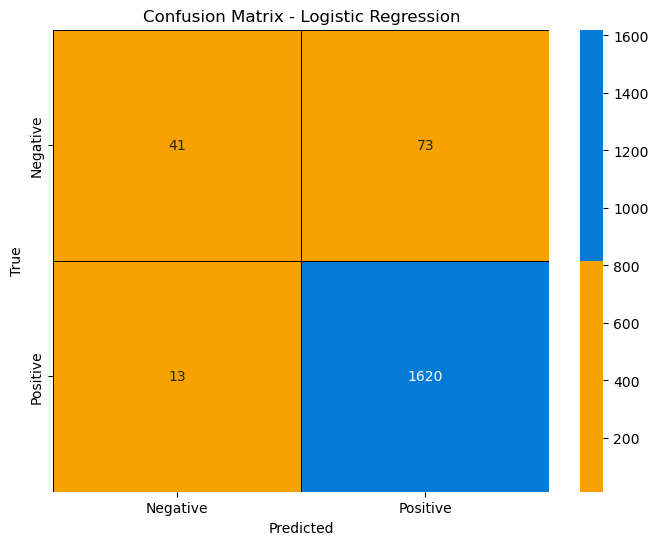

Accuracy Score (Logistic Regression): 0.9507727532913566


In [30]:
# Classifier 1: Logistic Regression
classifier1 = LogisticRegression()
classifier1.fit(x_train, y_train)
y_pred1 = classifier1.predict(x_test)

# Confusion matrix for Logistic Regression
cm1 = confusion_matrix(y_test, y_pred1)
print("Logistic Regression Classifier: ")

# Define custom colormap for Flipkart
flipkart_cmap = ListedColormap(['#f7a200', '#047bd5'])

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

acc1 = accuracy_score(y_test, y_pred1)

# Accuracy score for Logistic Regression
print("Accuracy Score (Logistic Regression):", acc1)

### 2. K-NN Classifier


K-Nearest Neighbors Classifier: 


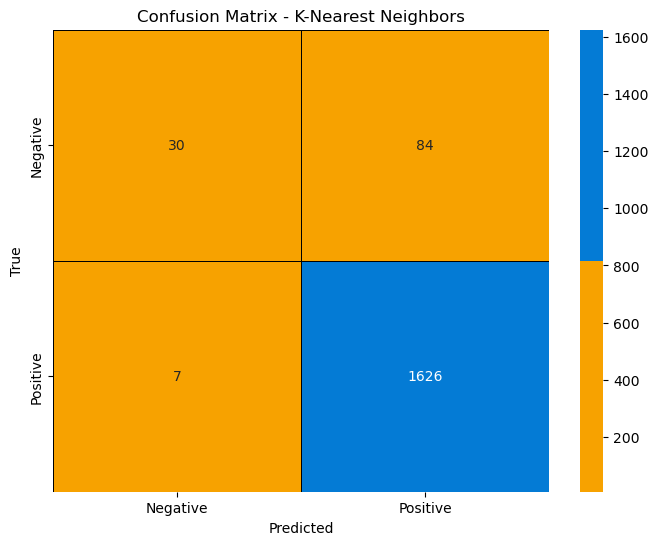

Accuracy Score (K-Nearest Neighbors): 0.9479107040641099


In [31]:
# Classifier 2: K-Nearest Neighbors
classifier2 = KNeighborsClassifier(
    n_neighbors=5, algorithm='auto', metric='manhattan', p=1)
classifier2.fit(x_train, y_train)
y_pred2 = classifier2.predict(x_test)

# Confusion matrix for K-Nearest Neighbors
cm2 = confusion_matrix(y_test, y_pred2)
print("\nK-Nearest Neighbors Classifier: ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.show()

acc2 = accuracy_score(y_test, y_pred2)
# Accuracy score for K-Nearest Neighbors
print("Accuracy Score (K-Nearest Neighbors):", acc2)

### 3. Kernel SVC 


Support Vector Classifier (RBF Kernel): 


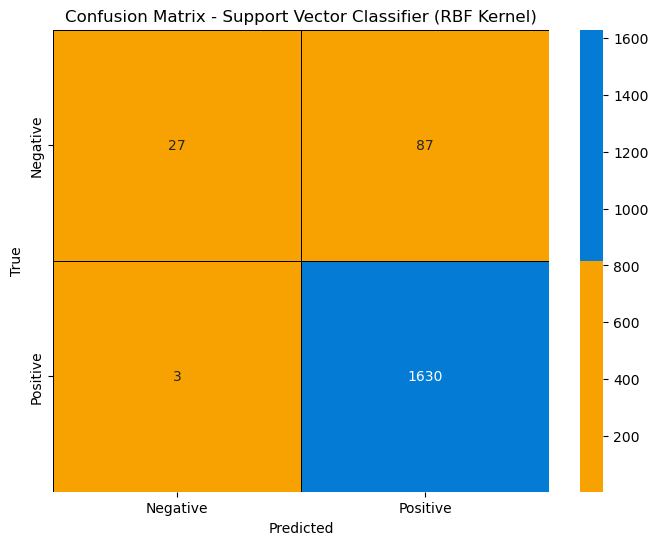

Accuracy Score (SVC - RBF Kernel): 0.9484831139095592


In [32]:
# Classifier 3: Support Vector Classifier with RBF Kernel
classifier3 = SVC(kernel='rbf')
classifier3.fit(x_train, y_train)
y_pred3 = classifier3.predict(x_test)

# Confusion matrix for SVC with RBF Kernel
cm3 = confusion_matrix(y_test, y_pred3)
print("\nSupport Vector Classifier (RBF Kernel): ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Support Vector Classifier (RBF Kernel)')
plt.show()

acc3 = accuracy_score(y_test, y_pred3)
# Accuracy score for SVC with RBF Kernel
print("Accuracy Score (SVC - RBF Kernel):", acc3)

### 4. Gaussian Navie Bayes Classifier


Gaussian Naive Bayes Classifier: 


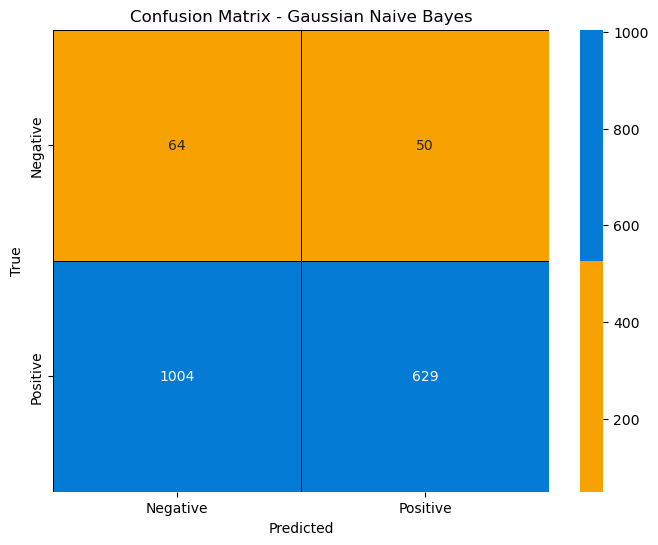

Accuracy Score (Gaussian Naive Bayes): 0.3966800228963938


In [33]:
# Classifier 4: Gaussian Naive Bayes
classifier4 = GaussianNB()
classifier4.fit(x_train, y_train)
y_pred4 = classifier4.predict(x_test)

# Confusion matrix for Gaussian Naive Bayes
cm4 = confusion_matrix(y_test, y_pred4)
print("\nGaussian Naive Bayes Classifier: ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm4, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.show()

acc4 = accuracy_score(y_test, y_pred4)

# Accuracy score for Gaussian Naive Bayes
print("Accuracy Score (Gaussian Naive Bayes):", acc4)

### 5. Decision Tree Classifier 


Decision Tree Classifier (Entropy Criterion): 


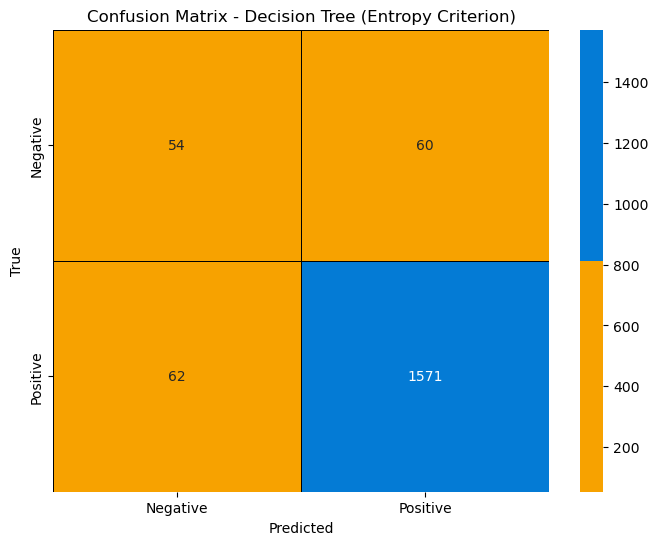

Accuracy Score (Decision Tree - Entropy Criterion): 0.9301659988551803


In [34]:
# Classifier 5: Decision Tree with Entropy Criterion
classifier5 = DecisionTreeClassifier(criterion='entropy')
classifier5.fit(x_train, y_train)
y_pred5 = classifier5.predict(x_test)

# Confusion matrix for Decision Tree with Entropy Criterion
cm5 = confusion_matrix(y_test, y_pred5)
print("\nDecision Tree Classifier (Entropy Criterion): ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm5, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Decision Tree (Entropy Criterion)')
plt.show()

acc5 = accuracy_score(y_test, y_pred5)
# Accuracy score for Decision Tree with Entropy Criterion
print("Accuracy Score (Decision Tree - Entropy Criterion):", acc5)

### 6. Random Forest Classifier


Random Forest Classifier (500 Estimators): 


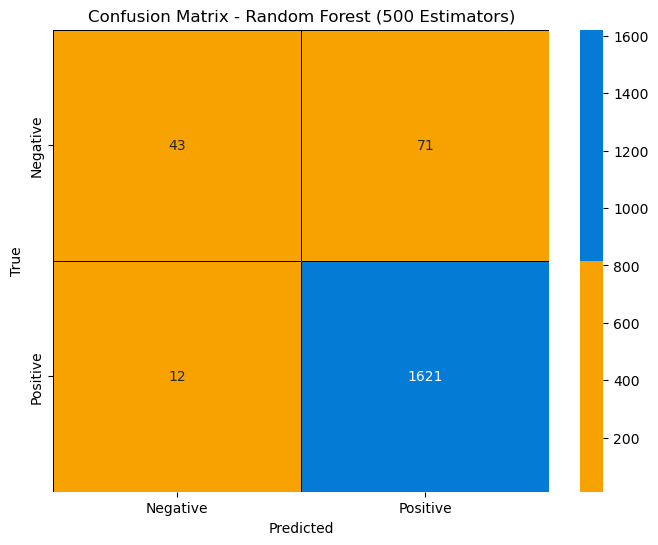

Accuracy Score (Random Forest - 500 Estimators): 0.9524899828277046


In [35]:
# Classifier 6: Random Forest with 500 Estimators
classifier6 = RandomForestClassifier(n_estimators=500, random_state=0)
classifier6.fit(x_train, y_train)
y_pred6 = classifier6.predict(x_test)

# Confusion matrix for Random Forest with 500 Estimators
cm6 = confusion_matrix(y_test, y_pred6)
print("\nRandom Forest Classifier (500 Estimators): ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm6, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (500 Estimators)')
plt.show()

acc6 = accuracy_score(y_test, y_pred6)
# Accuracy score for Random Forest with 500 Estimators
print("Accuracy Score (Random Forest - 500 Estimators):", acc6)

## ANN Classifier


MLP Classifier: 


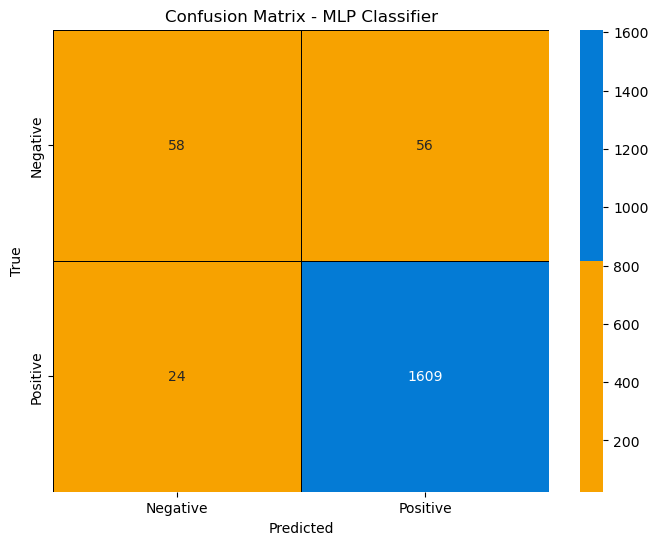

Accuracy Score (MLP Classifier): 0.9542072123640527


In [36]:
# Classifier 7: MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(
    100, 50, 10), activation='relu', solver='adam', max_iter=70, random_state=42)
mlp_classifier.fit(x_train, y_train)
y_pred_mlp = mlp_classifier.predict(x_test)

# Confusion matrix for MLP Classifier
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print("\nMLP Classifier: ")

# Plotting confusion matrix using Seaborn with custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap=flipkart_cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=.5, linecolor='black')  # Adjust linewidths and linecolor
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MLP Classifier')
plt.show()

# Accuracy score for MLP Classifier
acc7 = accuracy_score(y_test, y_pred_mlp)
print("Accuracy Score (MLP Classifier):", acc7)

## Accuracies of Different Models 

In [53]:
classifiers = [
    "Logistic Regression",
    "K-NN Classifier",
    "Kernel SVC",
    "Naive Bayes Classifier",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "MLP/ANN Classifier"
]

accuracies = [acc1, acc2, acc3, acc4, acc5, acc6, acc7]

max_length = max(len(classifier) for classifier in classifiers)

for classifier, accuracy in zip(classifiers, accuracies):
    formatted_classifier = f"{classifier}:"
    print(f"{formatted_classifier.ljust(max_length + 2)} {round(accuracy * 100, 3)}%")

Logistic Regression:       95.077%
K-NN Classifier:           94.791%
Kernel SVC:                94.848%
Naive Bayes Classifier:    39.668%
Decision Tree Classifier:  93.017%
Random Forest Classifier:  95.249%
MLP/ANN Classifier:        95.421%


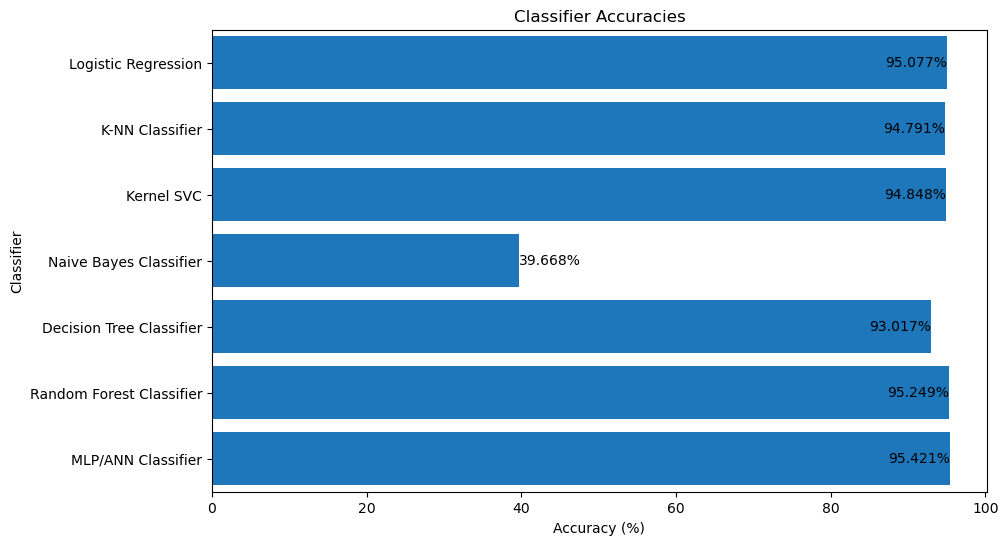

In [57]:
acc_df = pd.DataFrame({'Classifier': classifiers, 'Accuracy': [
                      round(acc * 100, 3) for acc in accuracies]})

# Plotting the bar chart using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Accuracy', y='Classifier', data=acc_df, color='#047bd5')
plt.xlabel('Accuracy (%)')
plt.title('Classifier Accuracies')

# Adding accuracy values inside the bars with dynamic positioning
for index, value in enumerate(accuracies):
    plt.text(value * 100, index, f'{round(value * 100, 3)}%',
             va='center', fontsize=10, ha='left' if value < 0.9 else 'right')

plt.show()

These results suggest strong performance from Logistic Regression, K-NN, Kernel SVC, Decision Tree, Random Forest, and MLP/ANN classifiers, while Naive Bayes trails behind in this specific task.

## Creating World Cloud

In [75]:
def generate_word_cloud(text, title, stopwords=None):
    if stopwords is None:
        stopwords = set(STOPWORDS)

    wordcloud = WordCloud(width=1000, height=1000,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

### Splitting the Reviews into Positive & Negative Subparts

In [70]:
positive_reviews = []
negative_reviews = []

for i in range(len(data)):
    if data['New_Rating'][i] == 1:
      positive_reviews.append(data['New'][i])
    else :
      negative_reviews.append(data['New'][i])

In [71]:
positive_reviews

['wow superb camera phone smooth speed lag iphon king alway beauti product',
 'brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart',
 'awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help',
 'guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed',
 'thank flipkart trust got devic perfect love best phone segment',
 'excel product worth everi penni write review use day earlier use iphon plus iphon faster anyth els excel pictur qualiti love',
 'first iphon ever bought earn money part time job colleg tech freak trust view bionic fastest effici reliabl processor till date camera focus quick take dslr qualiti photo screen size inch comfort screen size ole retina xdr display crisp everyth feel real stereo speaker clear even high volum',
 'delight phone pho

In [72]:
negative_reviews

['overal perform phone good expect appl major overh problem phone minor usag charg even authent w charger phone feel real hot even minor usag especi upper left side left side charg phone get hot not warm like liter hot plug charger minut avoid heat know problem devic general',
 'use oneplus pro year old devic still better batteri backup iphon rest know iphon great camera nice screen io smooth consist mani android phone lack face id pain covid boy give charger suck overal nice phone batteri better',
 'appl fan find iphon light easier use iphon compact size weight display littl better iphon speed also better satisfactori disappoint charger earphon box also price strategi appl product india posit much higher develop countri way round capac pay peopl develop nation like india much lower th',
 'overal good mobil apart call big brand noth special camera gud not wow like samsung ultra current use yes perform realli top class not see lag batteri could better',
 'flipkart support bad',
 'receiv

In [73]:
df = pd.DataFrame(data = positive_reviews, columns = ["Postive_Reviews"] )
df

,Postive_Reviews
0,wow superb camera phone smooth speed lag iphon king alway beauti product
1,brand trustworthi got genuin pice low cost order green one trust colour amaz colour specif green purpl nice look thank flipkart
2,awesom phone valu money happi batteri life awesom camera featur look imag snap use phone easi use fear get scratch back glass use cover help
3,guy beast everi aspect configur full pack want like best camera best display best batteri whole day use everyon know process speed
4,thank flipkart trust got devic perfect love best phone segment
...,...
5449,one word great job appl
5450,receiv desir
5451,camera qualiti
5452,buy


### Full Word Cloud

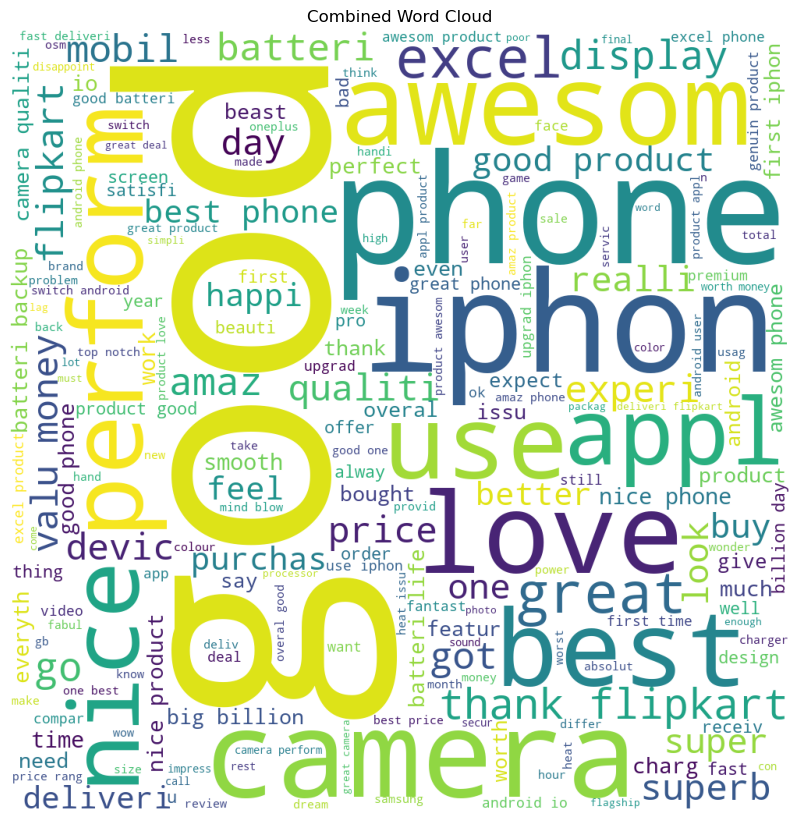

In [78]:
# Combine Positive and Negative Reviews for a Comprehensive Word Cloud
combined_comments = positive_comments + ' ' + negative_comments
generate_word_cloud(combined_comments, 'Combined Word Cloud')

### World Cloud for Positive Reviews

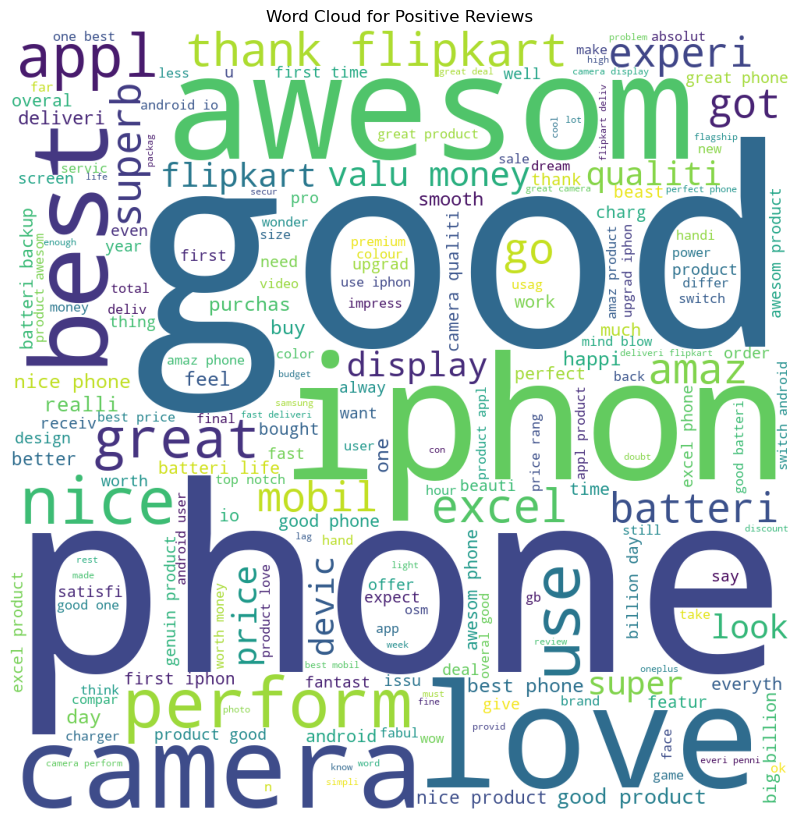

In [76]:
# Combine Positive Reviews for a Word Cloud
positive_comments = ' '.join(str(review) for review in positive_reviews)
generate_word_cloud(positive_comments, 'Word Cloud for Positive Reviews')

### World Cloud for Negative Reviews

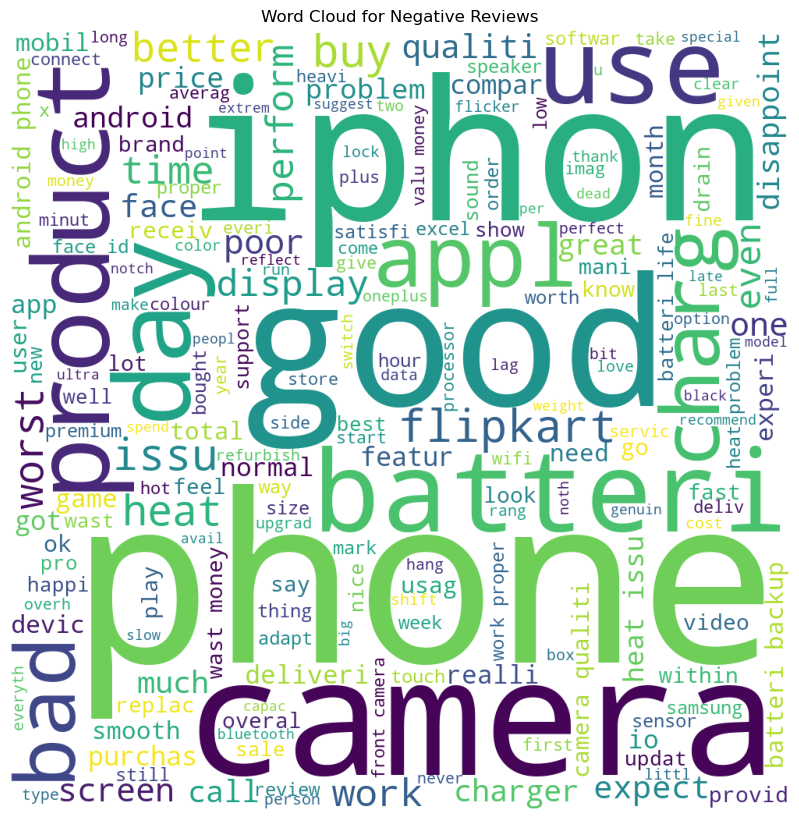

In [77]:
# Combine Negative Reviews for a Word Cloud
negative_comments = ' '.join(str(review) for review in negative_reviews)
generate_word_cloud(negative_comments, 'Word Cloud for Negative Reviews')

# For a new Review, Predicting whether its Positive or Negative

### Function to clean the text in new Review 

In [65]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def convert(new_review):
  review = re.sub('[^a-zA-Z]', ' ', new_review[0])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  all_words = stopwords.words('english')
  all_words.remove('not')
  review = [ snow_stemmer.stem(i) for i in review if not i in set(all_words) ]
  review = ' '.join(review)
  corpus.append(review)

  from sklearn.feature_extraction.text import CountVectorizer
  new_x_test = cv.transform(corpus).toarray()
  return new_x_test[-1]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
new_review = input("Enter New Review: ")

if classifier6.predict([convert([new_review])]) == 1:
  print("Positve")
else :
  print("Negative")

Positve


- Here are we are able to Predict whether a given review is positive or negative.

### Conclusion

- Just by entering the name of product, We are able to know its Major pro's & cons without actually going through all the reviews on Flipkart
- For any new review, We are also able to predict whether its Positive or Negative
- Both Customers & Company personels can get to know the product's sentiment without much hazzle 